In [2]:
### standard sci-py libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot ### to read, convert, inspect ROOT TTrees
from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import analysis_utils
from hipe4ml import plot_utils

In [28]:
hdl_mc = TreeHandler("/eos/user/h/hsharma/HyperLoop_Output_Run3/MC_train_112361_LHC22b1b/LcSignal.root", "LcSignal")
hdl_totalBkg = TreeHandler("/eos/user/h/hsharma/HyperLoop_Output_Run3/DATA_train_Lc_112997/LcData_df_0_40.root", "LcData")
print('MC: ',len(hdl_mc), ' | Bkg: ',len(hdl_totalBkg), ' | S/B: ', round(len(hdl_mc)/len(hdl_totalBkg),3))

# this is the fraction of data you want to take from the hdl_totalBkg daraframe

fractionBkg=1

hdl_totalBkg.shuffle_data_frame(frac=fractionBkg, inplace=True)


# excluding the mass region -----------
# print('-----------------------------------')
# gaus_sigma=0.009
# gaus_mean=2.284
# nSigmaRegion=5

# lowMassEdge= round(gaus_mean - (nSigmaRegion*gaus_sigma/2.0), 2)
# highMassEdge = round(gaus_mean + (nSigmaRegion*gaus_sigma/2.0), 2)

# cutStr=f'fM <  {lowMassEdge}  |  fM >  {highMassEdge}'  

# print(cutStr)
# print('Signal exclusion region: ', lowMassEdge, ' --- ', highMassEdge)
# hdl_bkg = hdl_totalBkg.apply_preselections(cutStr, inplace=False)
# print('MC: ',len(hdl_mc) , ' | Bkg : ', len(hdl_bkg), ' | S/B: ', round(len(hdl_mc)/len(hdl_bkg),3))


# ---------------------------------------------
# split the MC sample

hdl_mc_1=hdl_mc
hdl_mc_2=hdl_mc

dfmc=hdl_mc.get_data_frame()
dfmc=dfmc.query('fM > 2.2 & fM <2.4')

np.random.seed(42)

num_rows = dfmc.shape[0]
split_ratio = 0.4  # Adjust the ratio as needed
entries_sample_1 = int(num_rows * split_ratio)

indices_sample_1 = np.random.choice(num_rows, entries_sample_1, replace=False)
indices_sample_2 = np.setdiff1d(np.arange(num_rows), indices_sample_1)
df_sample_1 = dfmc.iloc[indices_sample_1]
df_sample_2 = dfmc.iloc[indices_sample_2]

#----------------------------------------
# split the data sample
hdl_data_1=hdl_totalBkg
hdl_data_2=hdl_totalBkg

hdl_totalSample_2=hdl_totalBkg

dfData=hdl_totalBkg.get_data_frame()
dfData.query('fM > 2.2 & fM <2.4',inplace=True)

np.random.seed(42)

num_rows_data = dfData.shape[0]
split_ratio = 0.4  # Adjust the ratio as needed
entries_sample_1 = int(num_rows_data * split_ratio)

indices_sample_1 = np.random.choice(num_rows_data, entries_sample_1, replace=False)
indices_sample_2 = np.setdiff1d(np.arange(num_rows_data), indices_sample_1)
dfData_sample_1 = dfData.iloc[indices_sample_1]
dfData_sample_2 = dfData.iloc[indices_sample_2]

#----------------------------------------

hdl_mc_1.set_data_frame(df_sample_1)
hdl_mc_2.set_data_frame(df_sample_2)

hdl_data_1.set_data_frame(dfData_sample_1)
hdl_data_2.set_data_frame(dfData_sample_2)

# hdl_data = TreeHandler("/eos/user/h/hsharma/XicMLTrees/DATA/XicBkg.root", "XicBkg")
# hdl_bkg = hdl_data.apply_preselections("fM < 2.42 or fM > 2.5", inplace=False)
# print('Size of samples \nData = ',len(hdl_bkg), ', MC = ', len(hdl_mc))
# print('----------------------------------')



# # Samples for training
# fractionData=0.01 # this is the fraction of total data used in training 
# hdl_bkg.shuffle_data_frame(frac=fractionData, inplace=True)
# print('Size of samples for training \nData = ',len(hdl_bkg), ', MC = ', len(hdl_mc))

MC:  78284  | Bkg:  3227708  | S/B:  0.024


In [29]:
sample1_ratio = round(df_sample_1.shape[0]/dfData_sample_1.shape[0], 3)
sample2_ratio = round(df_sample_2.shape[0]/dfData_sample_2.shape[0], 3)

print("type \t| sample 1 \t| sample 2 \t| mc/data ratio")
print("----------------------------------------------------")
print("MC \t| " ,df_sample_1.shape[0], " \t| ", df_sample_2.shape[0], " \t| ", sample1_ratio)
print("Data \t| " ,dfData_sample_1.shape[0], " \t| ", dfData_sample_2.shape[0], " \t| ", sample2_ratio)

type 	| sample 1 	| sample 2 	| mc/data ratio
----------------------------------------------------
MC 	|  31199  	|  46799  	|  0.024
Data 	|  1291083  	|  1936625  	|  0.024


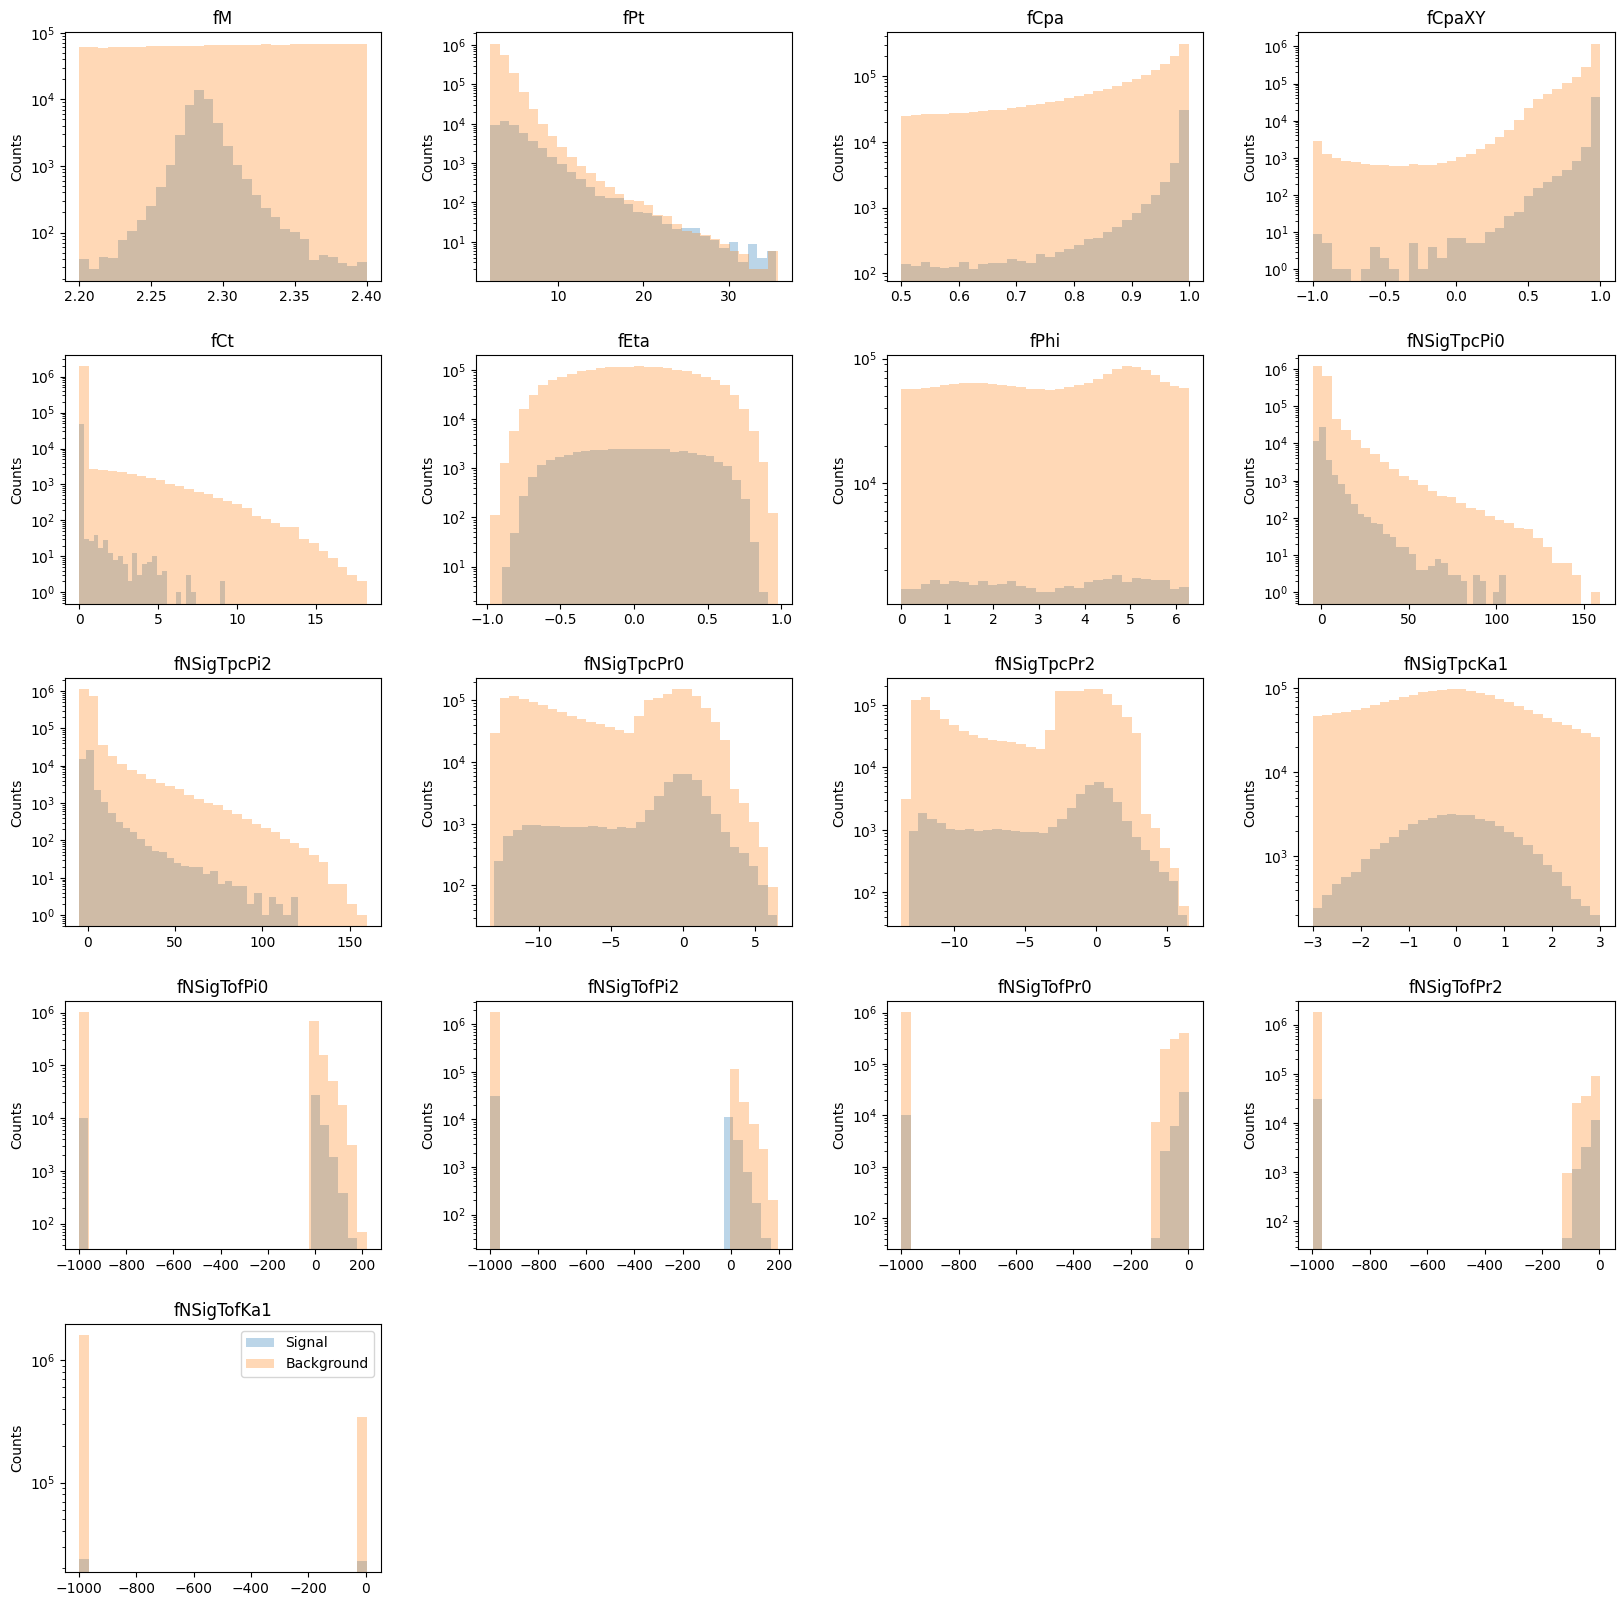

In [30]:
cols_to_be_compared = ['fM','fPt','fCpa','fCpaXY','fCt','fEta','fPhi', 'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
                           'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1']

## some matplotlib tuning is needed to display all the features
plot_utils.plot_distr([hdl_mc_1,hdl_data_1], cols_to_be_compared, 
                      bins=30, labels=['Signal', 'Background'],
                      log=1, density=0, figsize=(20, 20), alpha=0.3, grid=False);

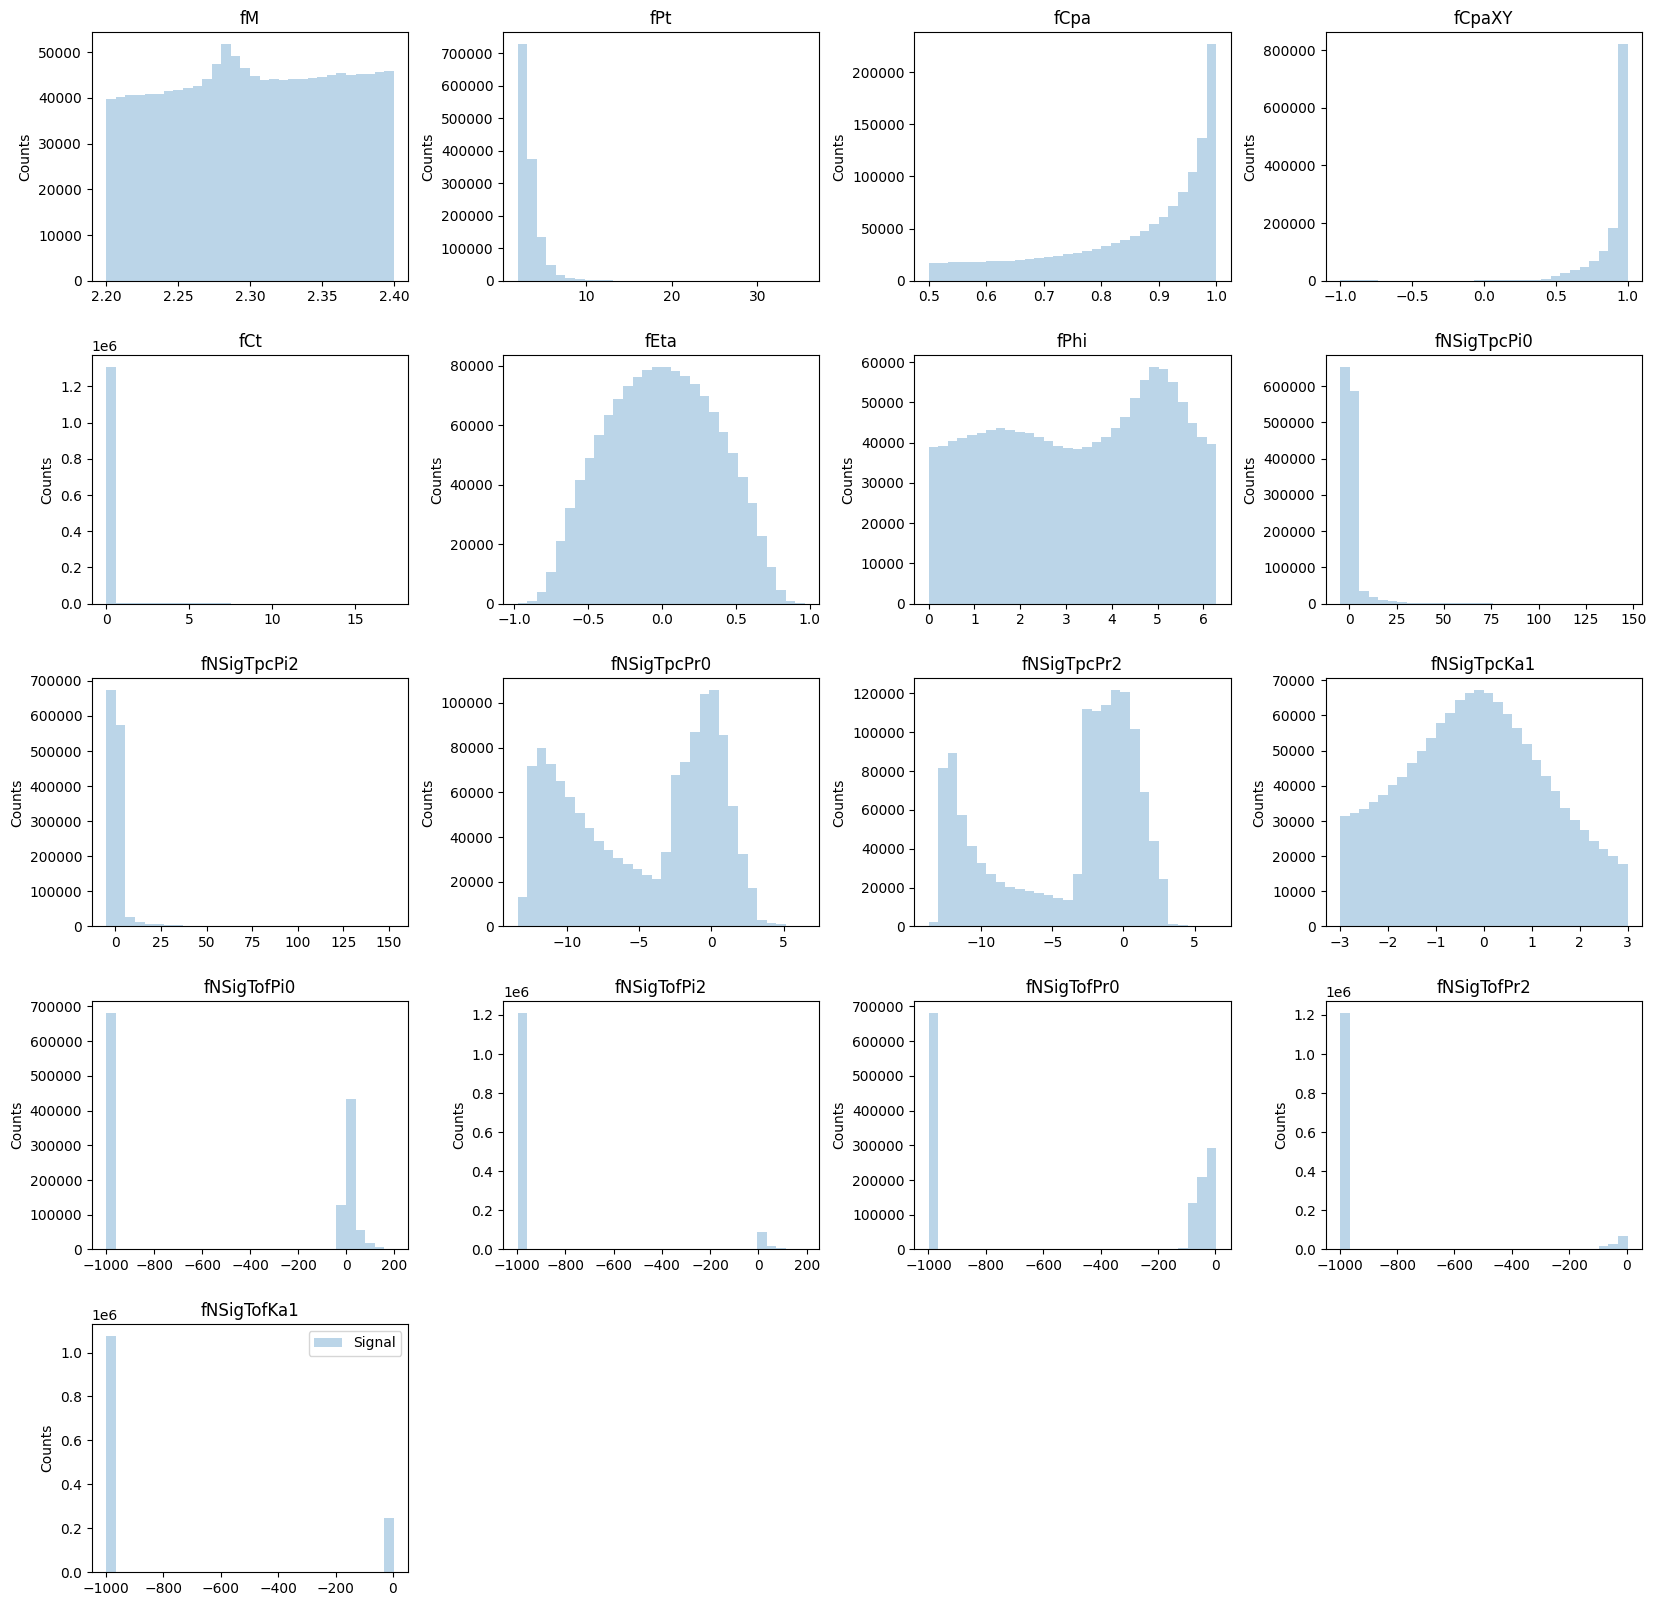

In [31]:
# merge the mc_sample_2 and data_sample_2
dfTotal_sample_2 = pd.concat([df_sample_1,dfData_sample_1])

plot_utils.plot_distr([dfTotal_sample_2], cols_to_be_compared, 
                      bins=30, labels=['Signal', 'Background'],
                      log=0, density=0, figsize=(20, 20), alpha=0.3, grid=False);



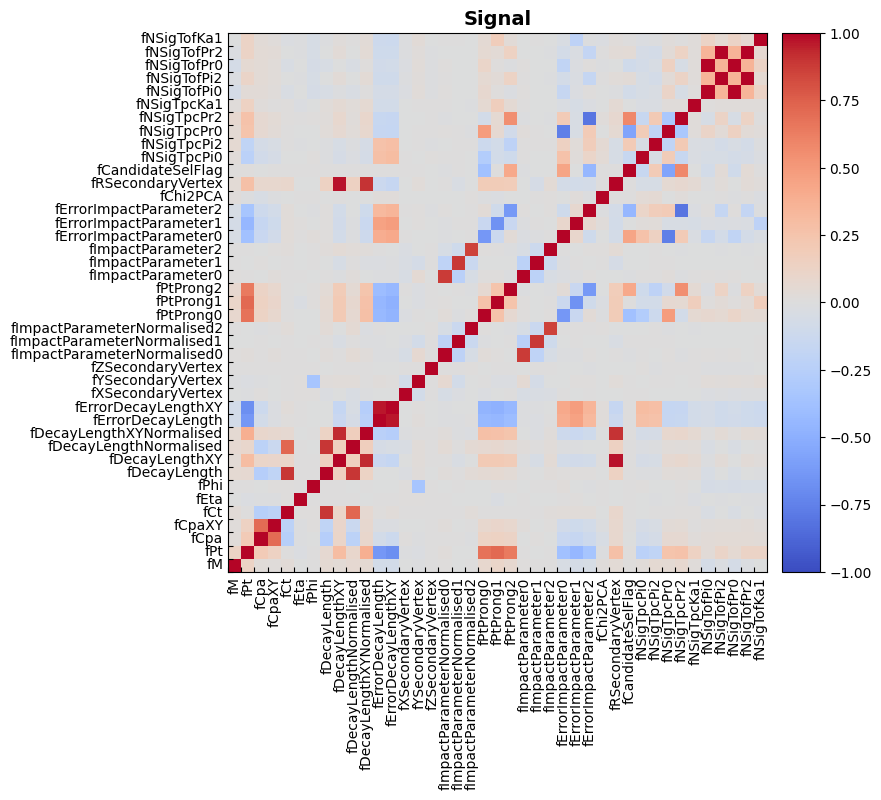

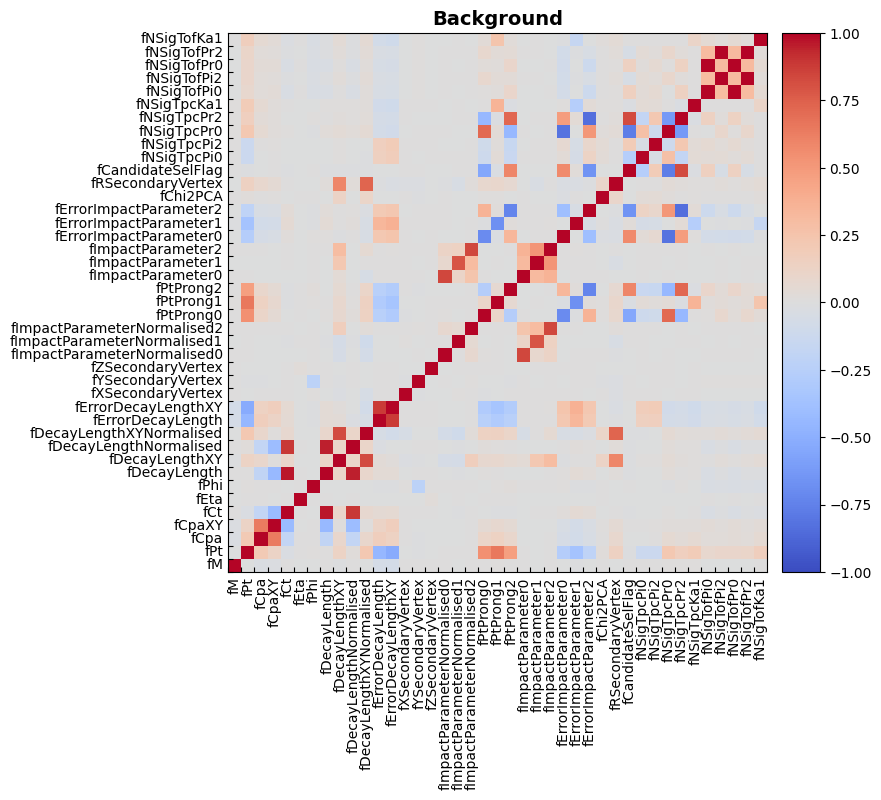

In [32]:
# convert df into hdl 

hdl_totalSample_2.set_data_frame(dfTotal_sample_2)

cols_to_be_compared = ['fM','fPt','fCpa','fCpaXY','fCt','fEta','fPhi', 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised', 'fDecayLengthXYNormalised',  'fErrorDecayLength', 'fErrorDecayLengthXY', 
                            'fXSecondaryVertex', 'fYSecondaryVertex','fZSecondaryVertex',
                           'fImpactParameterNormalised0', 'fImpactParameterNormalised1', 'fImpactParameterNormalised2',
                           'fPtProng0', 'fPtProng1', 'fPtProng2',
                           'fImpactParameter0', 'fImpactParameter1','fImpactParameter2',
                           'fErrorImpactParameter0', 'fErrorImpactParameter1', 'fErrorImpactParameter2', 'fChi2PCA', 'fRSecondaryVertex', 'fCandidateSelFlag',
                           'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
                           'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1']

## some matplotlib tuning is needed to display all the features
#  plot_utils.plot_distr([hdl_mc,hdl_bkg], cols_to_be_compared, 
#                       bins=30, labels=['Signal', 'Background'],
#                       log=0, density=0, figsize=(20, 20), alpha=0.3, grid=False);

plot_utils.plot_corr([hdl_mc_1,hdl_data_1], cols_to_be_compared, labels=['Signal', 'Background']);

#### Some questions....
- Which variables do we expect to be relevant for the training? Can we use all of them? Pros  and cons?
- why do we see some spikes in the DCA?

And correlations are important as well: the model can potentially exploit them to perform a better classification. Moreover, there could be some potentially dangerous correlations as those with the invariant mass of the particle of interest

Considerations? Doubts? Let's now define the training columns and build the training sample


In [33]:
# training_cols = ['fCpa','fCpaXY','fCt','fEta','fPhi', 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised','fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
#                 'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1', 'fErrorDecayLength' , 'fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']

# training_cols = ['fCpa','fCt','fDecayLength', 'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1','fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']
# training_cols = ['fCpa','fCt','fDecayLength', 'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1','fErrorDecayLengthXY', 'fChi2PCA', 'fRSecondaryVertex']




training_cols = ['fCpa','fCpaXY','fPt',
                 'fDecayLength', 'fDecayLengthXY', 'fDecayLengthNormalised', 'fDecayLengthXYNormalised',
                 'fCt',
                 'fXSecondaryVertex', 'fYSecondaryVertex','fZSecondaryVertex',
                           'fImpactParameterNormalised0', 'fImpactParameterNormalised1', 'fImpactParameterNormalised2',
#                            'fPtProng0', 'fPtProng1', 'fPtProng2',
#                            'fImpactParameter0', 'fImpactParameter1','fImpactParameter2',
#                            'fErrorImpactParameter0', 'fErrorImpactParameter1', 'fErrorImpactParameter2',
#                  'fNSigTofPi0','fNSigTofPi2','fNSigTofPr0','fNSigTofPr2','fNSigTofKa1',
#                  'fNSigTpcPi0','fNSigTpcPi2','fNSigTpcPr0','fNSigTpcPr2','fNSigTpcKa1',
                 'fChi2PCA',
                 'fRSecondaryVertex'
                ]
# train_test_data is a combined dataset of data and MC
train_test_data = analysis_utils.train_test_generator([hdl_mc_1, hdl_data_1], [0, 1], test_size=0.5, random_state=42)

print('Size of train sample: ', len(train_test_data[0]))
print('Size of test sample: ', len(train_test_data[3]))


Size of train sample:  684540
Size of test sample:  684541


## Training and testing a BDT

We will use the BDT of XGBoost (https://github.com/dmlc/xgboost): boosting is implemented with a gradient descent method. It features few hyperparameters that can be tuned to improve the performance and reduce the overfitting, even if the algorithm works smoothly out of the box.



In [34]:
import xgboost as xgb
n_estimators=168
max_depth=2
learning_rate=0.26

xgb_model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

model_hdl = ModelHandler(xgb_model, training_cols)

## Optimize the model on the provided data

from optuna.samplers import RandomSampler

N_JOBS=8

hyper_pars_ranges = {'n_estimators': (20, 300), 'max_depth': (2, 6), 'learning_rate': (0.01, 0.1)}
rnd_study = model_hdl.optimize_params_optuna(train_test_data, hyper_pars_ranges, cross_val_scoring='roc_auc',
                                             timeout=60, n_jobs=N_JOBS, n_trials=20, direction='maximize',
                                             optuna_sampler=RandomSampler())

In [36]:
from optuna.samplers import RandomSampler

N_JOBS=-1

hyper_pars_ranges = {'n_estimators': (20, 200), 'max_depth': (1, 3), 'learning_rate': (0.01, 0.4)}
rnd_study = model_hdl.optimize_params_optuna(train_test_data, hyper_pars_ranges, cross_val_scoring='roc_auc',
                                             timeout=60, n_jobs=N_JOBS, n_trials=10, direction='maximize',
                                             optuna_sampler=RandomSampler())

[I 2023-08-10 16:48:41,540] A new study created in memory with name: no-name-3782474c-abbb-4ec5-a261-5a722c7e6e53
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

Number of finished trials: 20
Best trial:
Value: 0.9343859159771715
Params: 
    n_estimators: 173
    max_depth: 3
    learning_rate: 0.17284880788347967


In [35]:
model_hdl.fit(train_test_data[0], train_test_data[1])

Training Done! Let's apply the model to the test sample

In [36]:
score_test = model_hdl.predict(train_test_data[2])

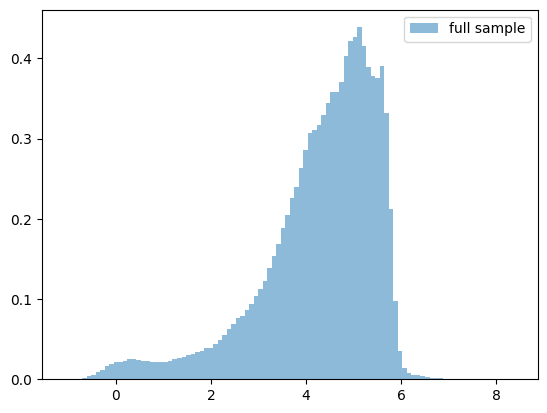

In [37]:
#### plot the score distribution
plt.hist(score_test, bins=100, label='full sample', alpha=0.5, density=True);
plt.legend();

Two peaks clearly distinguishable: will they be corresponding to the signal and the background? Let's plot the two distribution separately

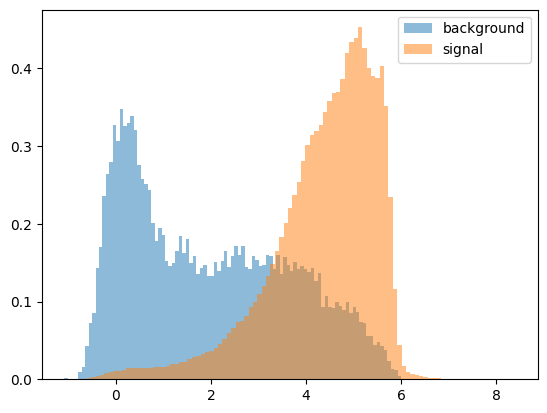

In [38]:
plt.hist(score_test[train_test_data[3]==0], bins=100, label='background', alpha=0.5, density=True);
plt.hist(score_test[train_test_data[3]==1], bins=100, label='signal', alpha=0.5, density=True);
plt.legend();


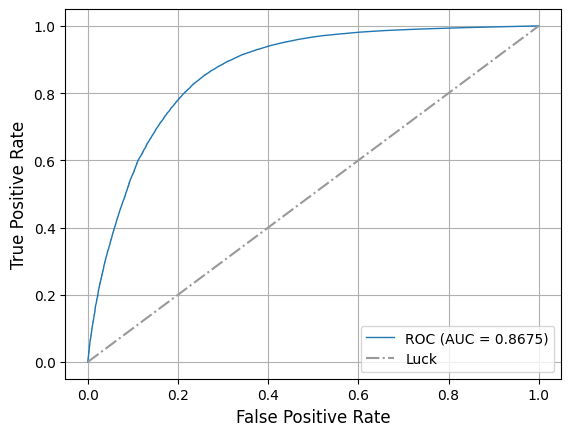

In [39]:
plot_utils.plot_roc(train_test_data[3], score_test);

Repeat this exercise with the training set: what do you get?

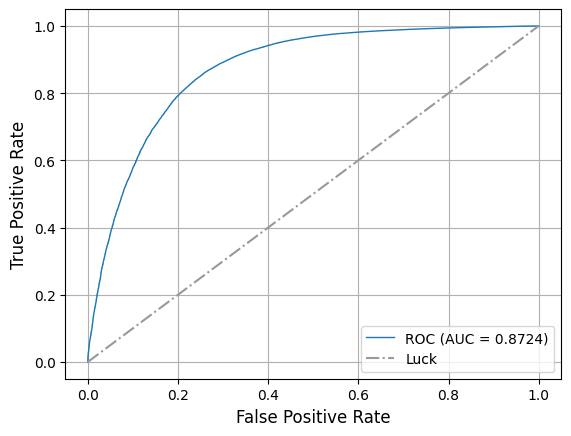

In [40]:
score_train = model_hdl.predict(train_test_data[0])
plot_utils.plot_roc(train_test_data[1], score_train);

Training ROC-AUC is slightly higher than the test set one. This is a systematic behaviour due to the small presence of overfitting. We can see it also by plotting the BDT output for the training and test set distributions

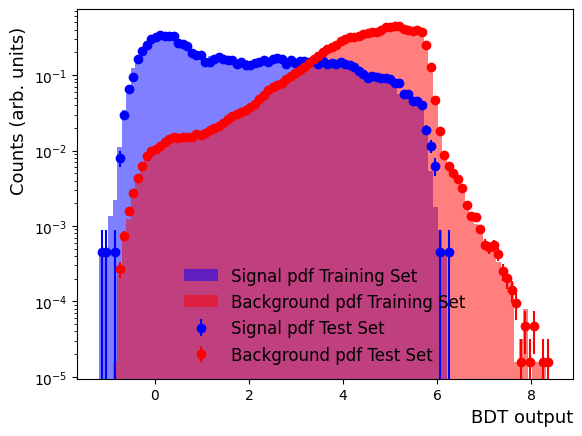

In [41]:
plot_utils.plot_output_train_test(model_hdl, train_test_data, density=True, bins=100, logscale=True);

Now, before applying the BDT to data we can have a look at which variables are relevant for the training. We will use the feature importance implemented in the SHAP library (https://github.com/slundberg/shap). In the context of machine learning, the Shapley value is used to evaluate the contribution of each feature to the model output, and it is calculated by averaging the marginal contributions of each feature to the model output. The marginal contribution of a feature is the difference in the model output when the feature is present or absent. The variables that are
more important for the model are those that have a higher marginal contribution, and Shapley values consequently.

In hipe4ml the function plot_feat_imp implements the algorithm: try to use it!

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


[<Figure size 1800x900 with 2 Axes>, <Figure size 1800x900 with 1 Axes>]

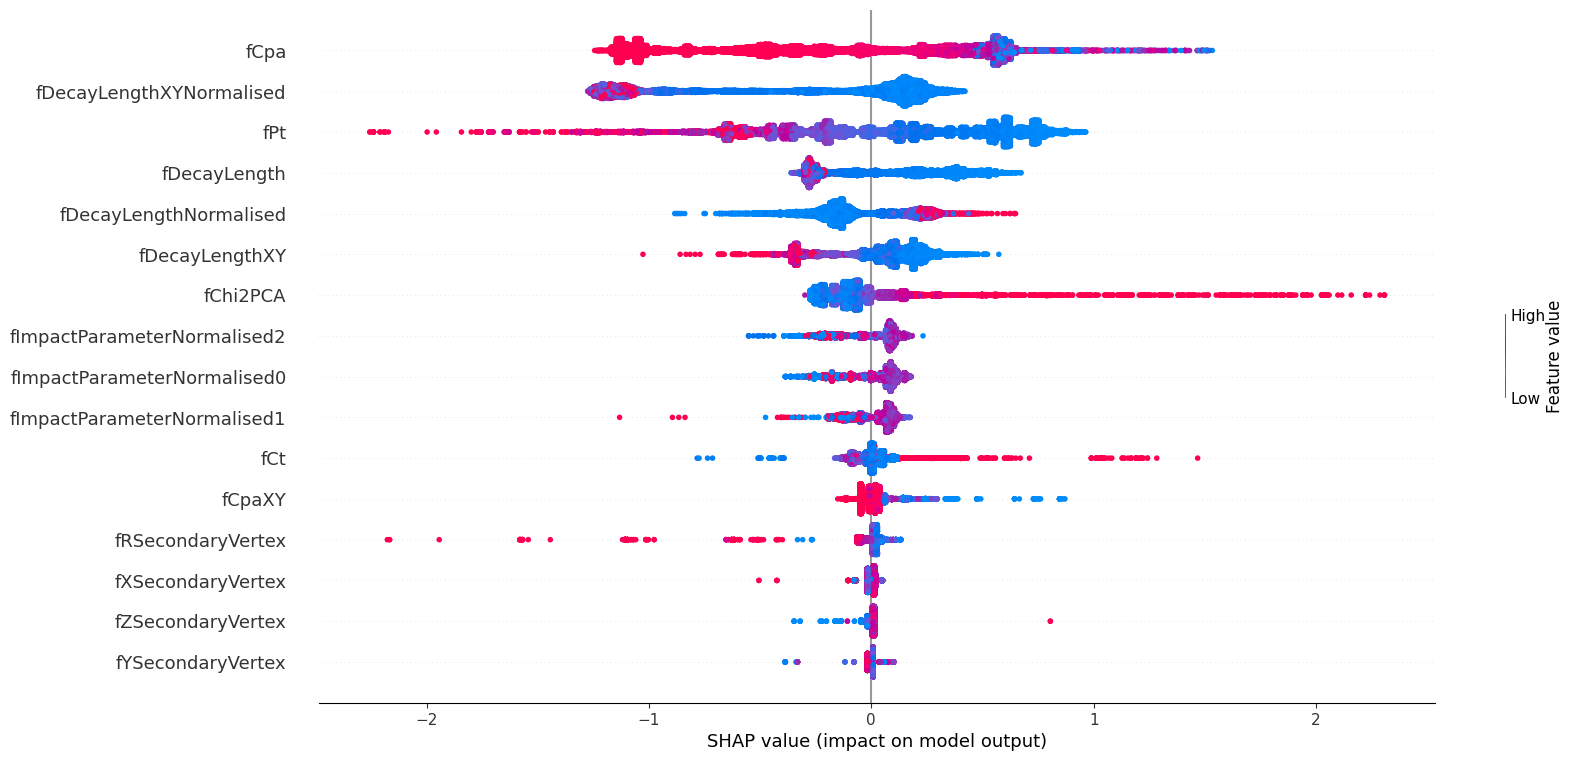

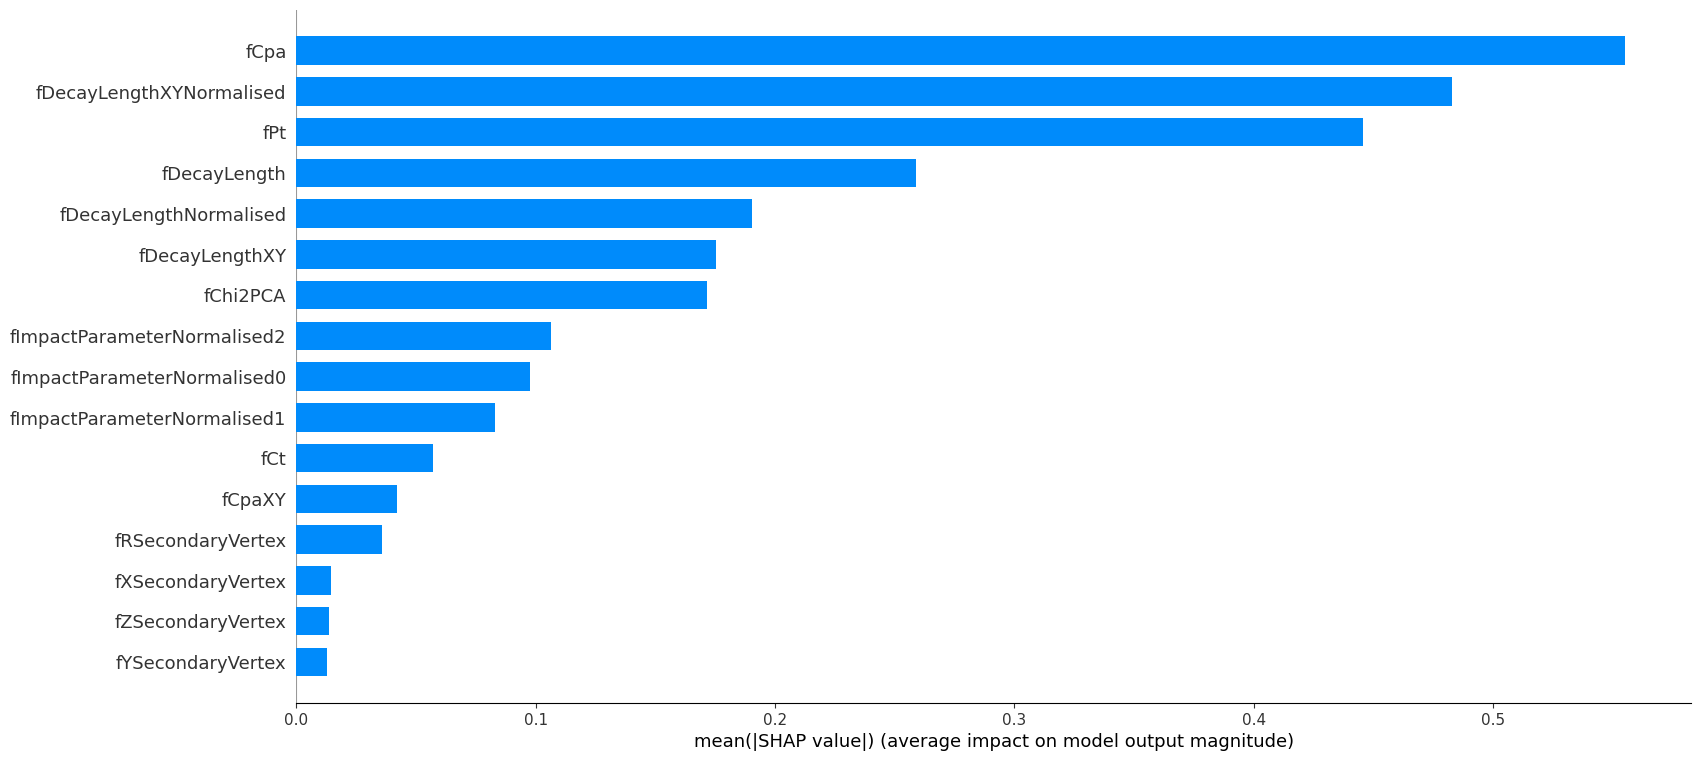

In [42]:
plot_utils.plot_feature_imp(train_test_data[2], train_test_data[3], model_hdl) 

Two plots given: how to interpret them?

**Bonus** : repeat the training using a different model and compare its performance with the XGB BDT. All the sklearn and keras (NN) models can be used to feed the ModelHandler

### Applying the BDT

Now that the model is tested we can use it to classify the real data sample. Try to evaluate the invariant mass as a function of the score distribution

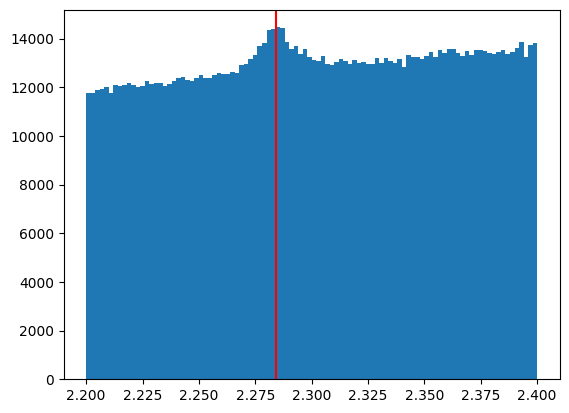

In [50]:
hdl_totalSample_2.apply_model_handler(model_hdl)
plt.hist(hdl_totalSample_2.apply_preselections("model_output>1", inplace=False)["fM"], bins=100);
plt.axvline(2.284, 0, 1, label='pyplot vertical line',color='r')

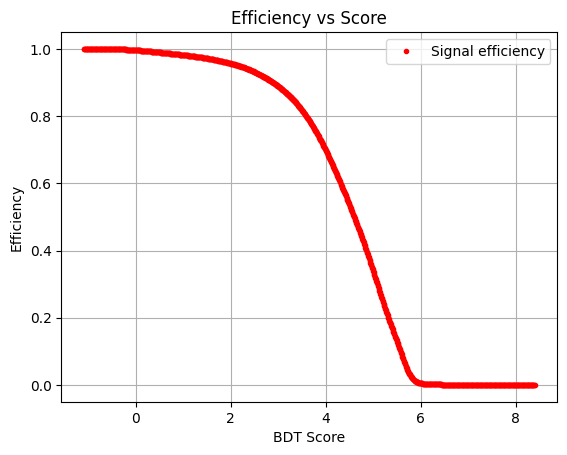

In [44]:
### hipe4ml has a function to do that! 
eff_array, score_array = analysis_utils.bdt_efficiency_array(train_test_data[3], score_test, 1000)
plot_utils.plot_bdt_eff(score_array, eff_array);

In [44]:
## Now we can try to fit the invariant mass spectrum

In [48]:
from scipy.optimize import curve_fit
from scipy import integrate

def fit_invmass(df, fit_range=[1.660, 1.685]):
    
    # histogram of the data
    counts, bins = np.histogram(df, bins=40, range=fit_range)
    
    # define functions for fitting    
    def gaus_function(x, N, mu, sigma):
        return N * np.exp(-(x-mu)**2/(2*sigma**2))
    
    def pol2_function(x, a, b):
        return (a + x*b)
    
    def fit_function(x, a, b, N, mu, sigma):
        return pol2_function(x, a, b) + gaus_function(x, N, mu, sigma)
    
    # x axis ranges for plots
    x_point = 0.5 * (bins[1:] + bins[:-1])
    r = np.arange(fit_range[0], fit_range[1], 0.00001)
    
    # fit the invariant mass distribution with fit_function() pol2+gauss
    popt, pcov = curve_fit(fit_function, x_point, counts, p0 = [100, -1, 100, 1.673, 0.001])
    
    # plot data
    plt.errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='.', ecolor='k', color='k', elinewidth=1., label='Data')
    
    # plot pol2 and gauss obtained in the fit separately
    plt.plot(r, gaus_function(r, N=popt[2], mu=popt[3], sigma=popt[4]), label='Gaus', color='red')
    plt.plot(r, pol2_function(r, a=popt[0], b=popt[1]), label='pol2', color='green', linestyle='--')

    # plot the global fit
    plt.plot(r, fit_function(r, *popt), label='pol2+Gaus', color='blue')
    
    # compute significance of the signal
    signal = integrate.quad(gaus_function, fit_range[0], fit_range[1], args=(popt[2], popt[3], popt[4]))[0] / 0.00225
    background = integrate.quad(pol2_function, fit_range[0], fit_range[1], args=(popt[0], popt[1]))[0] / 0.00225
    print(f'Signal counts: {signal:.0f}')
    print(f'Background counts: {background:.0f}')     
    significance = signal / np.sqrt(signal + background)

    # Add some axis labels
    plt.legend()
    plt.xlabel('$M_{\Lambda\pi}$ $(\mathrm{GeV/}\it{c}^2)$')
    plt.ylabel('Counts')
    plt.show()


In [49]:
fit_invmass(hdl_data.apply_preselections("model_output>4", inplace=False)["mass"], fit_range=[1.660, 1.685])

KeyError: 'mass'

In [ ]:
### you can also use some packages for implementing ROOT like plots in python
import mplhep as hep
hep.style.use(hep.style.ROOT)

In [ ]:
fit_invmass(hdl_data.apply_preselections("model_output>0.5", inplace=False)["mass"], fit_range=[1.660, 1.685])

In [ ]:
#### reset matplotlib style if needed
plt.style.use('default')